### Creating a case network
1. Randomly select load profile for a single day
2. Limit the profile to night window
3. Create a generator column (sgen)
4. Select a time window. Assign power value to the sgen column
5. Repeat steps 1-4 for desired number of loads/sgens in the network

 ___

### Case variables
- Number of sgens can vary from 1 to max
- Charging time window (of 1hr?) can vary between _20:00_ and _6:00_
- Number of coordinating house owners can vary from 0 to all

        - Parties don't charge EVs at the same time; assume "one after another" approach
        - Neigboring parties can reduce local load. Distant partners reduce overall load


### Evaluation criteria and metrics
- Max line load (inc. overload)
- Visualisation of network line load


### Scenarios
- Uncoordinated charging
- (Semi-)coordinated charging
- Critical scenario: max number of EVs, all charging at the same time

___

### Energy community effectiveness evaluation
Consider _n_ cases (i.e. variations of network loads) per scenario (i.e. coordinated / uncoordinated charging)

FOR _x_ IN range(_n_) :
        
        1. Create case network from random historical load profiles
        2. Run timeseries on time window
        3. Calculate max line load(s), save output to df

Calculate probability of line overload per scenario.

In [1]:
import os
import pandas as pd

import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
matplotlib.rcParams['timezone'] = 'Europe/Berlin'

import data_process_base
import importlib
importlib.reload(data_process_base)

try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]

In [2]:
"""
Data processing for power flow time-step iteration

"""

# create random time series from import data
da = data_process_base.DataAction()
keep_cols = ['DE_KN_residential1_grid_import',
             'DE_KN_residential2_grid_import',
             'cet_cest_timestamp']
da.imp_procc("house_data.csv", keep_cols)
night_merge = da.power_merge()

# assign generator value at random times
sgen_val = 0.01 # typical val: 0.010 MW = 10kW
night_mw = da.sgen_rand(night_merge, sgen_val)

# replace index for pandapower controller module
test_set = night_mw.copy()
test_set.index = range(0, test_set.shape[0])
test_set.head()

Number of data frame segments =  90
dfList created successfully.


,load_1,sgen_1,load_2,sgen_2,load_3,sgen_3,load_4,sgen_4
0,0.017578,0.0,0.012012,0.0,0.008789,0.0,0.006006,0.01
1,0.005859,0.0,0.006006,0.0,0.008789,0.0,0.006006,0.01
2,0.005859,0.0,0.006006,0.0,0.017871,0.0,0.009009,0.01
3,0.015234,0.0,0.006006,0.0,0.009082,0.0,0.003003,0.01
4,0.009375,0.0,0.000000,0.0,0.009082,0.0,0.003003,0.01


<AxesSubplot:xlabel='date_time'>

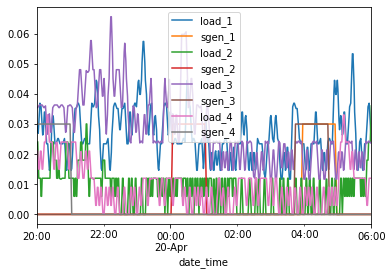

In [3]:
night_mw.rolling(3).sum().plot()

In [4]:
# create network
net = pn.four_loads_with_branches_out()
pp.create_sgen(net, 6, p_mw=0, name='sgen_1', q_mvar=0)
pp.create_sgen(net, 7, p_mw=0, name='sgen_2', q_mvar=0)
pp.create_sgen(net, 8, p_mw=0, name='sgen_3', q_mvar=0)
pp.create_sgen(net, 9, p_mw=0, name='sgen_4', q_mvar=0)
net.load.name.at[0] = "load_1"
net.load.name.at[1] = "load_2"
net.load.name.at[2] = "load_3"
net.load.name.at[3] = "load_4"

In [5]:
# create controllers
ds = DFData(test_set)
ConstControl(net, element="sgen", variable="p_mw", element_index=net.sgen.index,
             profile_name=["sgen_1","sgen_2","sgen_3","sgen_4"], data_source=ds)
ConstControl(net, element="load", variable="p_mw", element_index=net.load.index,
             profile_name=["load_1","load_2","load_3","load_4"], data_source=ds)
net.controller

,object,in_service,order,level,initial_run,recycle
0,ConstControl [sgen.p_mw],True,-1.0,-1,False,"{'trafo': False, 'gen': False, 'bus_pq': True}"
1,ConstControl [load.p_mw],True,-1.0,-1,False,"{'trafo': False, 'gen': False, 'bus_pq': True}"


In [6]:
# create output writer to store results
path = '..\\results\\'
ow = OutputWriter(net, time_steps=range(0, test_set.shape[0]), output_path=path, output_file_type=".xlsx")
ow.log_variable('res_line', 'loading_percent')
# ow.log_variable('res_line', 'i_ka')
ow.log_variable('res_load', 'p_mw')
# ow.log_variable('res_bus', 'vm_pu')

# run timeseries calculation
run_timeseries(net, time_steps=range(0, test_set.shape[0]))

100%|██████████| 601/601 [00:05<00:00, 113.07it/s]


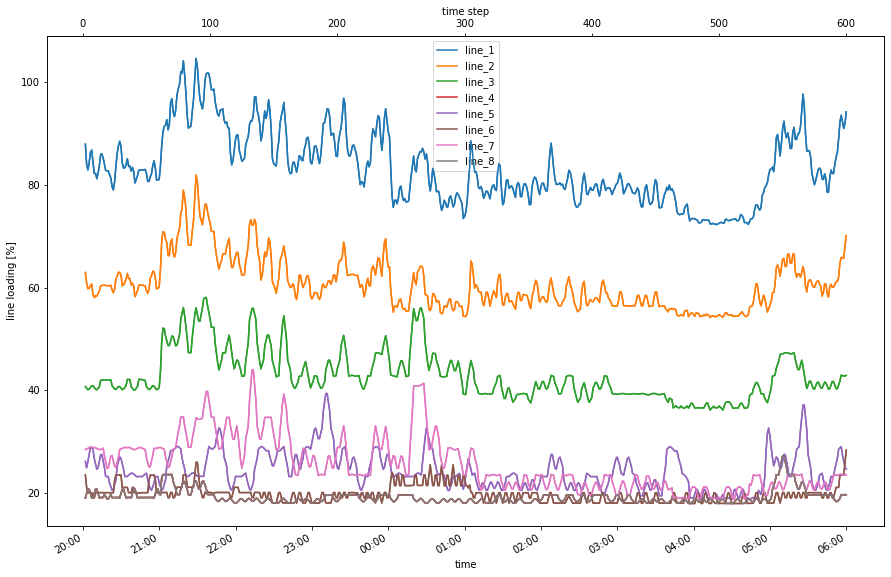

'\nPlot p_mw\n\n'

In [7]:
"""
Plot line loading

"""

# line loading results
ll_file = os.path.join(path, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.columns = line_loading.columns.astype('str')
names1 = {'0': 'line_1', '1': 'line_2', '2': 'line_3','3': 'line_4','4': 'line_5',
          '5': 'line_6', '6': 'line_7', '7': 'line_8'}
line_loading.rename(columns = names1, inplace=True)
ll = line_loading.rolling(3).sum()


fig, ax = plt.subplots(figsize=(15,10))
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M')

ax.plot(night_mw.index, ll.values)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()

secax = ax.twiny()
secax.plot(ll.index, ll.values)

ax.set_ylabel("line loading [%]")
ax.set_xlabel("time")
secax.set_xlabel('time step')
ax.legend(list(names1.values()))

plt.show()



"""
Plot p_mw

"""

# # res load results
# p_mw_file = os.path.join(path, "res_load", "p_mw.xlsx")
# p_mw = pd.read_excel(p_mw_file, index_col=0)
# p_mw.columns = p_mw.columns.astype('str')
# names2 = {'0': 'load_1', '1': 'load_2', '2': 'load_3','3': 'load_4'}
# p_mw.rename(columns = names2, inplace=True)
# p_mw = p_mw.rolling(3).sum()


# fig, ax = plt.subplots(figsize=(15,10))
# hours = mdates.HourLocator(interval = 1)
# h_fmt = mdates.DateFormatter('%H:%M')

# ax.plot(night_mw.index, p_mw.values)
# ax.xaxis.set_major_locator(hours)
# ax.xaxis.set_major_formatter(h_fmt)
# fig.autofmt_xdate()

# secax = ax.twiny()
# secax.plot(p_mw.index, p_mw.values)

# ax.set_ylabel("vm_pu")
# ax.set_xlabel("time")
# secax.set_xlabel('time step')
# ax.legend(list(names2.values()))

# plt.show()


<AxesSubplot:>

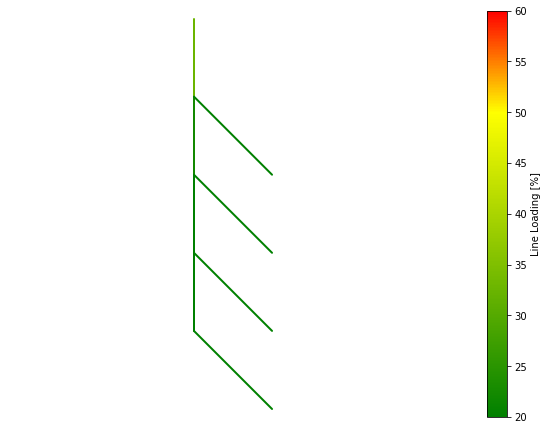

In [8]:
# update net with value 
# run_timeseries(net, time_steps=(0,0))

cmap_list=[(20, "green"), (50, "yellow"), (60, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2, use_bus_geodata=True)
plot.draw_collections([lc], figsize=(8,6))